## 1. Load Necessary Libraries

In [42]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import os
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import datetime as dt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error


## 2. Set seed for reproducibility

In [43]:
# -----------------------------
# Reproducibility
# -----------------------------
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

if torch.cuda.is_available():
    print("CUDA is available. Setting seed for all GPUs.")
    torch.cuda.manual_seed_all(RANDOM_SEED)

sns.set_style("darkgrid")


CUDA is available. Setting seed for all GPUs.


## 3. Set paths

In [44]:
# -----------------------------
# Project Root Resolution
# -----------------------------
PROJECT_ROOT = Path.cwd().resolve().parents[0]

DATA_RAW_DIR = PROJECT_ROOT / "data" / "raw"
DATA_INTERIM_DIR = PROJECT_ROOT / "data" / "interim"
DATA_PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"
MODELS_DIR = PROJECT_ROOT / "models"

DATA_INTERIM_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

DATA_RAW_DIR, DATA_INTERIM_DIR, FIGURES_DIR


(WindowsPath('C:/Users/Kinjal Mitra/Documents/stock-price-prediction-ff/data/raw'),
 WindowsPath('C:/Users/Kinjal Mitra/Documents/stock-price-prediction-ff/data/interim'),
 WindowsPath('C:/Users/Kinjal Mitra/Documents/stock-price-prediction-ff/reports/figures'))

## 4. Load Data from data/processed/

In [45]:
DATA_PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
DATA_PROCESSED_SPLITS_DIR = DATA_PROCESSED_DIR / "splits"

X_train = np.load(DATA_PROCESSED_SPLITS_DIR / "X_train.npy")
y_train = np.load(DATA_PROCESSED_SPLITS_DIR / "y_train.npy")

X_val = np.load(DATA_PROCESSED_SPLITS_DIR / "X_val.npy")
y_val = np.load(DATA_PROCESSED_SPLITS_DIR / "y_val.npy")

X_test = np.load(DATA_PROCESSED_SPLITS_DIR / "X_test.npy")
y_test = np.load(DATA_PROCESSED_SPLITS_DIR / "y_test.npy")

In [46]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(2604, 30, 31) (2604,)
(558, 30, 31) (558,)
(559, 30, 31) (559,)


## 5. Convert to PyTorch Datasets

In [47]:
BATCH_SIZE = 64

train_ds = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)

val_ds = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
)

test_ds = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


## 6. LSTM Architecture

In [48]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers, batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze()


## 7. GRU Architecture

In [49]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super().__init__()
        self.gru = nn.GRU(
            input_dim, hidden_dim, num_layers, batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :]).squeeze()


## 8. Training Utilities

In [50]:
def train_model(model, train_loader, val_loader, epochs=30, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val_loss = float("inf")
    best_state = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for Xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(Xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for Xb, yb in val_loader:
                preds = model(Xb)
                loss = criterion(preds, yb)
                val_loss += loss.item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()

        if epoch % 5 == 0:
            print(
                f"Epoch {epoch:02d} | "
                f"Train Loss: {train_loss/len(train_loader):.6f} | "
                f"Val Loss: {val_loss/len(val_loader):.6f}"
            )

    model.load_state_dict(best_state)
    return model


## 9. Train Model

In [51]:
input_dim = X_train.shape[2]

lstm_model = LSTMModel(input_dim)
gru_model = GRUModel(input_dim)

print("\nTraining LSTM...")
lstm_model = train_model(lstm_model, train_loader, val_loader)

print("\nTraining GRU...")
gru_model = train_model(gru_model, train_loader, val_loader)



Training LSTM...
Epoch 00 | Train Loss: 0.000558 | Val Loss: 0.000514
Epoch 05 | Train Loss: 0.000102 | Val Loss: 0.000178
Epoch 10 | Train Loss: 0.000095 | Val Loss: 0.000257
Epoch 15 | Train Loss: 0.000085 | Val Loss: 0.000181
Epoch 20 | Train Loss: 0.000115 | Val Loss: 0.000272
Epoch 25 | Train Loss: 0.000074 | Val Loss: 0.000184

Training GRU...
Epoch 00 | Train Loss: 0.003589 | Val Loss: 0.009850
Epoch 05 | Train Loss: 0.000109 | Val Loss: 0.000186
Epoch 10 | Train Loss: 0.000099 | Val Loss: 0.000190
Epoch 15 | Train Loss: 0.000092 | Val Loss: 0.000229
Epoch 20 | Train Loss: 0.000090 | Val Loss: 0.000241
Epoch 25 | Train Loss: 0.000092 | Val Loss: 0.000221


## 10. Evaluate on Test Set (Log Returns)

In [52]:
def evaluate(model, loader):
    model.eval()
    preds, actuals = [], []

    with torch.no_grad():
        for Xb, yb in loader:
            preds.append(model(Xb).numpy())
            actuals.append(yb.numpy())

    return np.concatenate(actuals), np.concatenate(preds)


In [53]:
y_test_true, lstm_preds = evaluate(lstm_model, test_loader)
_, gru_preds = evaluate(gru_model, test_loader)


## 11. Inverse Price Reconstruction


Load original price series

In [54]:
price_df = pd.read_csv(DATA_RAW_DIR / "StockPrice.csv")
prices = price_df["Price"].values


Align prices with test window

In [55]:
SEQ_LEN = X_train.shape[1]
start_idx = len(prices) - len(y_test_true) - 1

last_prices = prices[start_idx : start_idx + len(y_test_true)]

Reconstruct prices

In [56]:
def reconstruct_prices(last_prices, log_returns):
    return last_prices * np.exp(log_returns)

In [57]:
lstm_price_preds = reconstruct_prices(last_prices, lstm_preds)
gru_price_preds = reconstruct_prices(last_prices, gru_preds)
actual_prices = reconstruct_prices(last_prices, y_test_true)


## 12. Model Metrics

In [58]:
lstm_mae = mean_absolute_error(actual_prices, lstm_price_preds)
lstm_rmse = root_mean_squared_error(actual_prices, lstm_price_preds)
lstm_r2 = r2_score(actual_prices, lstm_price_preds)

print("LSTM – Log Return Metrics")
print(f"MAE  : {lstm_mae:.6f}")
print(f"RMSE : {lstm_rmse:.6f}")
print(f"R²   : {lstm_r2:.4f}")

print ("\nGRU – Log Return Metrics")
gru_mae = mean_absolute_error(actual_prices, gru_price_preds)
gru_rmse = root_mean_squared_error(actual_prices, gru_price_preds)
gru_r2 = r2_score(actual_prices, gru_price_preds)
print(f"MAE  : {gru_mae:.6f}")
print(f"RMSE : {gru_rmse:.6f}")
print(f"R²   : {gru_r2:.4f}")






LSTM – Log Return Metrics
MAE  : 27.015884
RMSE : 29.729423
R²   : 0.9172

GRU – Log Return Metrics
MAE  : 14.509552
RMSE : 17.493519
R²   : 0.9713


## 12. Plot and Save Price Predictions

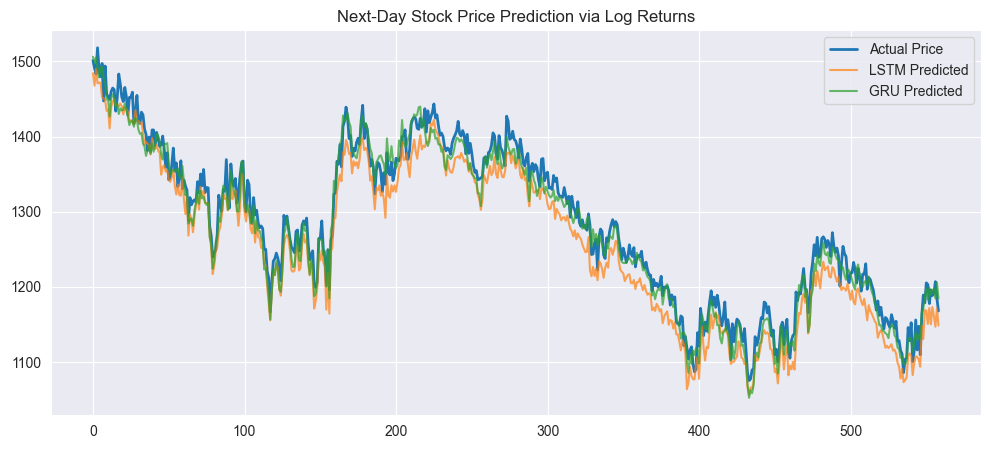

In [59]:
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label="Actual Price", linewidth=2)
plt.plot(lstm_price_preds, label="LSTM Predicted", alpha=0.7)
plt.plot(gru_price_preds, label="GRU Predicted", alpha=0.7)
plt.legend()
plt.title("Next-Day Stock Price Prediction via Log Returns")
plt.show()


In [60]:
torch.save(lstm_model.state_dict(), MODELS_DIR / "lstm_model.pt")
torch.save(gru_model.state_dict(), MODELS_DIR / "gru_model.pt")

print("Models saved successfully.")


Models saved successfully.
